## Simulation of light intensity measurements via ray tracing

This notebook simulates light intensity measurements by performing ray tracing for Gaussian beams interacting with Lambertian targets. It models multiple illumination sources and generates the resulting full-waveform intensity data.

**Note:** The code provided in this notebook is developed specifically for the research presented in the article *Simulation of ultrafast structured illumination in single-photon sensitive single-pixel lidar*. For additional details, please refer to the article or contact the authors.

### Required libraries
This notebook uses the following libraries:

- `matplotlib`
- `numpy`
- `pickle`
- `scipy`

In [1]:
# Importing necessary libraries

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, ScalarFormatter
import numpy as np
import pickle
import scipy

### Parameters of the simulation

The transmitted power of a truncated Gaussian beam is modelled as a Gaussian function in the time domain:
$$P_0(t) = \frac{E}{\sqrt{2\pi \sigma^2}} \exp{\left(-\frac{(t-\Delta t/2)^2}{2 \sigma^2}\right)},$$
where $\sigma > 0$ is chosen so that
$$\int_0^{\Delta t} P_0(t)\mathrm{d}t \approx E.$$

The irradiance distribution of the truncated cone-shaped beam is given by:
\begin{align}
\mathcal{I}(x, y, z; t)=\begin{cases}
\frac{2P_0(t-\Vert (x, y, z)\Vert_2/c)}{\pi (1-e^{-2}) w(z)^2}\exp\left(-2\frac{x^2+y^2}{w(z)^2}\right), & \sqrt{x^2+y^2}\leqslant w(z),\\
0, & \text{otherwise,}
\end{cases}
\end{align}
where $w(z)=\theta z$ is the beam radius. This definition ensures that
$$\iint_{\Vert (x, y) \Vert_2 \leqslant w(z)} \mathcal{I}(x, y, z; t)\mathrm{d}x\mathrm{d}y = P_0(t).$$

In [2]:
# Parameters for the simulation
wavelength = 1550e-9 # Laser wavelength
divergence = 1e-3  # Divergence half-angle of the cone-shaped beam in radians
detector = np.array([0, 0, 0]) # Position of the detector as a single point in space
sampling_rate = 20e9  # Sampling rate in measurements per second

# Define parameters for the transmitted power in the time domain
sigma = 0.1e-9  # Standard deviation of the Gaussian pulse (in seconds)
pulse_length = 1e-9  # Duration of the pulse (in seconds)
pulse_energy = 1e-9  # Total energy of the pulse (in joules)

def total_power(t):
    """
    Calculate the transmitted power of the beam at time t.

    Parameters:
    t (float): The time at which to evaluate the transmitted power.

    Returns:
    float: The power of the beam at time t.
    """
    return (pulse_energy / (np.sqrt(2 * np.pi * sigma**2))) * \
           np.exp(-0.5 * (t - pulse_length / 2)**2 / sigma**2)

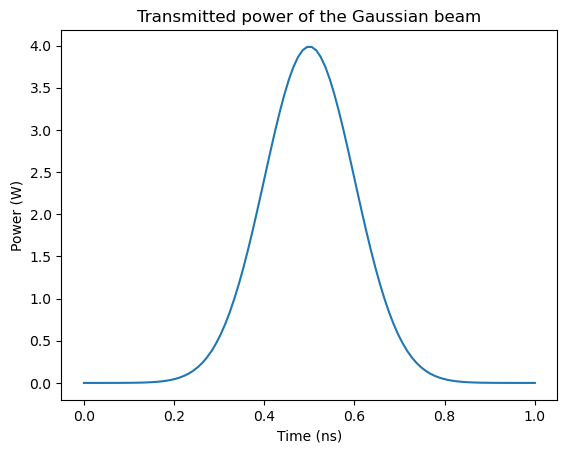

In [3]:
# Plotting the transmitted power

ts = np.linspace(0, 1e-9, 100)
plt.plot(ts * 1e9, total_power(ts))
plt.xlabel('Time (ns)')
plt.ylabel('Power (W)') 
plt.title('Transmitted power of the Gaussian beam')
plt.show()


### Laser source configuration

In [4]:
# VCSEL array configuration (n x n)
n = 4  # Number of VCSEL elements along each dimension

# Define the output dimensions of the VCSEL array
output_width = 5e-2 # Width of the output beam pattern in metres
output_height = output_width # Height of the output beam pattern in metres (assumed to be square)

source_width = 4.5e-3  # Physical width of each VCSEL element in metres
dist = (output_height - n * source_width) / (n - 1)  # Distance between centers of VCSEL elements

# List of VCSEL source positions
sources = []

for j in range(1, n + 1):
    for i in range(1, n + 1):
        sources.append(np.array([
                -output_width / 2 + source_width / 2 + (i - 1) * (source_width + dist),
                output_height / 2 - source_width / 2 - (j - 1) * (source_width + dist),
                0
            ])
        )
        

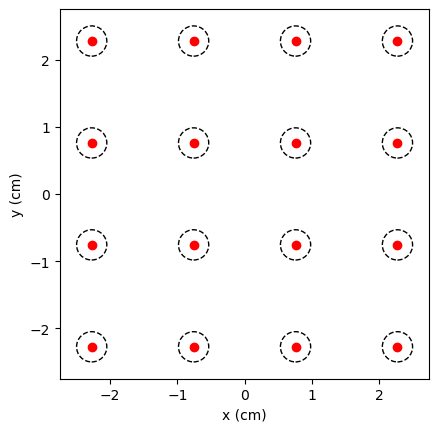

In [7]:
# Visualise the array configuration

fig, ax = plt.subplots()

for source in sources:
    x, y = 1e2*source[0], 1e2*source[1]
    circle = matplotlib.patches.Circle((x, y), 1e2*source_width / 2, edgecolor='black', facecolor='none', linestyle='--')
    ax.add_patch(circle)
    plt.scatter(x, y, color='red')

plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
ax.set_aspect('equal')
plt.show()


### Implementing objects in the simulation

The simulation accommodates two primary types of objects:
1. **Triangular faces**: Represented by three vertices $\boldsymbol{n}_1$, $\boldsymbol{n}_2$, and $\boldsymbol{n}_3$ in 3D space.
2. **Spheres**: Defined by a centre $\boldsymbol{c}\in \mathbb{R}^3$ and a radius $r>0$.


In [8]:
# Initialise a list of objects
objects = []

# Add a triangular face
objects += [{'n1': np.array([3, 4, 13]), 'n2': np.array([2, -4, 12]), 'n3': np.array([-6, -2, 4]), 'normal' : None , 'reflectance': 0.8, 'type' : 'planar'}]

# Add a sphere
# objects += [{'centre': np.array([0, 0, 12]), 'radius': 2, 'reflectance': 0.5, 'type': 'sphere'}]

# Precompute unit normals for triangular faces
for obj in objects:
    if obj['type'] == 'planar':
        normal = np.cross(obj['n1']-obj['n2'], obj['n3']-obj['n2'])
        normal = normal/np.linalg.norm(normal, 2)
        obj['normal'] = normal
        

### Initialisation of ray directions

Ray directions are represented as 3D unit vectors. The directions are uniformly distributed on the surface of a spherical cone, with an opening half-angle equal to the divergence of the beam. The initial ray directions are generated using the Fibonacci lattice method, which provides an efficient approximation of uniform distribution over the conical surface.

In [9]:
def generate_rays(N, divergence):
    """
    Generate `N` uniformly distributed rays within a spherical cone of a given opening half-angle.

    Parameters:
    N (int): Number of rays to generate.
    divergence (float): Half-angle of the spherical cone (in radians).

    Returns:
    np.ndarray: A 2D array of shape (N, 3), where each row is a direction vector [x, y, z].
    """
    # Generate the indices for the Fibonacci lattice
    golden_ratio = (1 + 5**0.5) / 2
    i = np.arange(0, N)
    
    # Calculate spherical coordinates
    theta = 2 * np.pi * i / golden_ratio  # Azimuthal angle
    phi = divergence * np.sqrt(i / N)     # Polar angle (adjusted for the cone)

    # Convert spherical coordinates to Cartesian coordinates
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    
    directions = np.column_stack((x, y, z))

    return directions


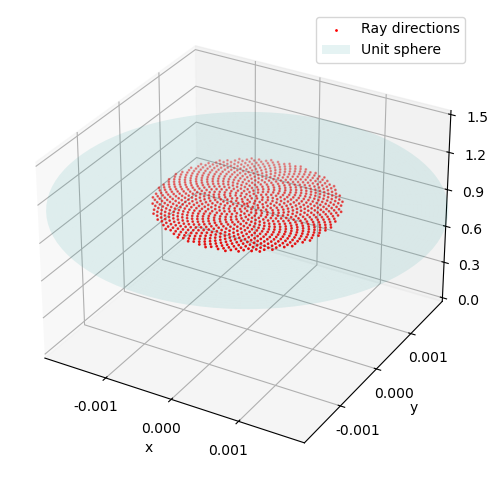

In [10]:
# Visualisation of ray directions

# Generate ray directions within a spherical cone
directions = generate_rays(1000, divergence) # Use 1,000 rays visualisation

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the ray directions
ax.scatter(directions[:, 0], directions[:, 1], directions[:, 2], c='r', s=1, label='Ray directions')

# Define the parameter ranges for plotting the unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi/1500, 100)

# Parametric equations for the unit sphere
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the unit sphere
ax.plot_surface(x, y, z, color='c', alpha=0.1, edgecolor='none', label='Unit sphere')

# Reduce the number of ticks and set decimal places for tick labels
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.zaxis.set_major_locator(MaxNLocator(5))

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim([-0.0015, 0.0015])
ax.set_ylim([-0.0015, 0.0015])
ax.set_zlim([0, 1.5])

plt.legend()
plt.show()


Choose the number of rays for the simulation:

In [11]:
# Set the number of rays for the simulation
Nrays = 1000

# Generate initial ray directions:
directions = generate_rays(Nrays, divergence) 

### Auxiliary functions

In [12]:
def object_intersection(obj, ray_origin, ray_direction):
    """
    Calculate the distance from the ray origin to the intersection point with a given object.

    Parameters:
    obj (dict): The object to intersect with. The dictionary must include the following keys based on the object type:
        - For 'planar' type:
            - 'type': Must be 'planar'.
            - 'n1': Vertex 1 of the triangular face (np.ndarray).
            - 'n2': Vertex 2 of the triangular face (np.ndarray).
            - 'n3': Vertex 3 of the triangular face (np.ndarray).
            - 'normal': Surface normal of the plane (np.ndarray).
            - 'reflectance': Reflectance of the planar object (float).
        - For 'sphere' type:
            - 'type': Must be 'sphere'.
            - 'centre': Centre of the sphere (np.ndarray).
            - 'radius': Radius of the sphere (float).
            - 'reflectance': Reflectance of the sphere (float).
    ray_origin (np.ndarray): The origin point of the ray (np.ndarray).
    ray_direction (np.ndarray): The direction vector of the ray (np.ndarray).

    Returns:
    float or None: The distance from the ray origin to the intersection point if it exists; otherwise, None.
    """
    
    if obj['type'] == 'planar':
        # Access the normal and vertices
        normal = obj['normal']
        n1 = obj['n1']
        n2 = obj['n2']
        n3 = obj['n3']

        # Check if the ray is parallel to the plane
        if np.dot(normal, ray_direction) == 0:
            return None  # No intersection
        
        # Solve for the intersection point
        A = np.column_stack((n1 - n2, n3 - n2, -ray_direction))
        x = np.linalg.solve(A, ray_origin - n2)
        alpha, beta, t = x

        # Check if the intersection is within the triangular face and forward in the direction of the ray
        # The condition t >= 1e-10 filters out very small values of t that might be due to numerical precision errors
        if 0 <= alpha <= 1 and 0 <= beta <= 1 and alpha + beta <= 1 and t >= 1e-10:
            distance = t
            return distance
        else:
            return None

    elif obj['type'] == 'sphere':
        # Compute the discriminant for the intersection equation
        centre = obj['centre']
        radius = obj['radius']
        oc = ray_origin - centre
        discriminant = np.dot(ray_direction, oc)**2 - (np.linalg.norm(oc, 2)**2 - radius**2) # Scaled discriminant

        if discriminant < 0:
            return None  # No intersection if discriminant is negative

        # Compute the distances to the intersection points
        sqrt_discriminant = np.sqrt(discriminant)
        dot_product = np.dot(ray_direction, oc)
        dist1 = -dot_product - sqrt_discriminant
        dist2 = -dot_product + sqrt_discriminant
        distances = np.array([dist1, dist2])
        distances = distances[distances >= 0]

        if distances.size == 0 or min(distances) < 1e-10:
            return None  # No valid intersection or intersection is too close to the origin

        return min(distances)
    
    else:
        raise ValueError("Unsupported object type: must be 'planar' or 'sphere'")
        

In [13]:
def nearest_intersected_object(objects, ray_origin, ray_direction):
    """
    Finds the nearest object that intersects with the ray.

    Parameters:
    -----------
    objects : list
        A list of objects in the scene, where each object is represented as a dictionary.
    ray_origin : np.ndarray
        A 3D vector representing the origin of the ray (starting point).
    ray_direction : np.ndarray
        A 3D unit vector representing the direction of the ray.

    Returns:
    --------
    nearest_object : dict or None
        The nearest object intersected by the ray, or None if no intersection occurs.
    min_distance : float
        The distance from the ray origin to the nearest intersection point. If no intersection occurs, 
        this will return `np.inf`.

    Notes:
    ------
    - The function calculates the distance between the ray origin and each object using the 
      `object_intersection` function.
    - The object with the smallest valid distance is identified as the nearest intersected object.
    """

    # Calculate the intersection distances from the ray to each object in the scene.
    distances = [object_intersection(obj, ray_origin, ray_direction) for obj in objects]
    
    # Initialise the nearest object as None and the minimum distance as infinity.
    nearest_object = None
    min_distance = np.inf
    
    # Loop through all the calculated distances to find the nearest intersection.
    for index, distance in enumerate(distances):
        # Check if the object was intersected and the distance is smaller than the current minimum.
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]  # Set the nearest object to the current one.
    
    # Return the nearest intersected object and the minimum distance to it.
    return nearest_object, min_distance


### Simulation execution

The contribution to the measured intensity at time $t$ from the $i$-th ray, originating at $\boldsymbol{r}_i = (x_i, y_i, 0)$, is calculated using the formula:
$$I_i(t)=\frac{P_0\left(t-\frac{\Vert \boldsymbol{x}^*- \boldsymbol{p}_i \Vert_2+ \Vert \boldsymbol{r}_i- \boldsymbol{p}_i \Vert_2}{c}\right)\exp\left(-2\frac{\left(p_{i{,}1}-x_i\right)^2+\left(p_{i{,}2}-y_i\right)^2}{\theta^2p_{i{,}3}^2}\right)}{M (1-e^{-2})\pi\Vert \boldsymbol{x}^*-\boldsymbol{p}_i \Vert_2^2}\rho_{m{,}i}\cos\varphi_i,$$
where 
* $\boldsymbol{x}^*$ is the position of the detector,
* $\boldsymbol{p}_i = (p_{i1}, p_{i2}, p_{i3})$ is the intersection point of the ray with the target,
* $\rho_{m,i}$ is the material reflectance at $\boldsymbol{p}_i$,
* $\varphi_i$ is the angle of incidence at $\boldsymbol{p}_i$,
* $M$ is the total number of rays representing the beam,
* $P_0(t)$ is the transmitted power as a function of time,
* $c$ is the speed of light,
* $\theta$ is the divergence half-angle of the beam.


In [14]:
def calculate_intensity_waveform(source, objects, t_min, t_max):
    """
    Simulates the measured intensity values as a function of time, from a single laser source, using ray tracing.

    Parameters:
    -----------
    source : numpy.ndarray
        The 3D coordinates of the laser source (origin of the rays).
    objects : list of dict
        List of objects in the scene. Each object is represented as a dictionary.
    t_min : float
        The start time for the intensity measurement in seconds.
    t_max : float
        The end time for the intensity measurement in seconds.

    Returns:
    --------
    ts : numpy.ndarray
        Array of time values between t_min and t_max, with intervals determined by the sampling rate.
    intensities : numpy.ndarray
        Corresponding intensity measurements at each time value.
    """

    # Initialise lists to store intersection points and reflectance*cosine factors
    intersection_points = []
    reflectance_cosine_factors = []

    # Precompute intersection points and reflectance*cosine factors for each ray
    for direction in directions:
        # Find the nearest object intersected by the ray
        intersected_object, distance_to_object = nearest_intersected_object(objects, source, direction)

        # Skip rays that do not hit any object
        if distance_to_object == 0 or intersected_object is None:
            continue

        # Calculate the intersection point between the ray and the object
        intersection_point = source + direction * distance_to_object

        # Determine the unit surface normal at the intersection point
        if intersected_object['type'] == 'planar':
            normal = intersected_object['normal']
        else:
            # For spherical objects, the normal is the vector from the center to the intersection point
            normal = (intersection_point - intersected_object['centre']) / intersected_object['radius']

        # Calculate the cosine of the angle of incidence
        cosine = np.abs(np.dot(normal, direction))
        reflectance = intersected_object['reflectance']

        # Calculate the reflectance * cosine factor for this ray
        reflectance_cosine_factor = reflectance * cosine

        # Store the intersection point and reflectance*cosine factor
        intersection_points.append(intersection_point)
        reflectance_cosine_factors.append(reflectance_cosine_factor)

    # Convert lists to numpy arrays for efficient computation
    intersection_points = np.array(intersection_points)
    reflectance_cosine_factors = np.array(reflectance_cosine_factors)

    # Determine the number of time samples based on the sampling rate and time window
    N_times = int(np.ceil(sampling_rate * (t_max - t_min)))

    # Create an array of time values between t_min and t_max
    ts = np.linspace(t_min, t_max, N_times)

    # Preallocate the intensities array to avoid repeated appending
    intensities = np.zeros(N_times)

    # Precompute the distances to the objects and detectors for each ray
    ray_vectors = intersection_points - source
    distances_to_object = np.linalg.norm(ray_vectors, axis=1)
    distances_to_detector = np.linalg.norm(intersection_points - detector, axis=1)
    total_distances = distances_to_object + distances_to_detector
    
    # Compute z-components, radial distances, and radii for each ray
    z_components = ray_vectors[:, 2]
    radial_distances = np.linalg.norm(ray_vectors[:, :2], axis=1)
    radii = divergence * z_components

    # Loop over each time value and compute the corresponding intensity
    for t_idx, t in enumerate(ts):
        intensity = 0  # Initialize total intensity for this time step

        # Loop over each ray and compute its contribution to the intensity
        for k in range(len(directions)):
            # Check if the ray contributes to the measured intensity at time t
            if t - pulse_length <= total_distances[k] / scipy.constants.c <= t:
                z_component = z_components[k]
                radial_distance = radial_distances[k]
                radius = radii[k]
                
                # Add the contribution of this ray to the total intensity at time t
                intensity += (
                    total_power(t - total_distances[k] / scipy.constants.c) *
                    np.exp(-2 * (radial_distance / radius) ** 2) *
                    reflectance_cosine_factors[k] /
                    (Nrays * np.pi * distances_to_detector[k] ** 2 * (1 - np.exp(-2)))
                )
                
        intensities[t_idx] = intensity  # Update intensity for the current time step

    return ts, intensities


In [15]:
# Collect data for all laser sources

# Initialise a list to store estimated arrival times for each source
estimated_arrival_times = []

# Iterate over each source to estimate arrival times
for source in sources:
    # Find the nearest intersected object along the z-axis
    _, distance_to_intersection = nearest_intersected_object(objects, source, np.array([0, 0, 1]))
    
    # Only consider sources that have a valid intersection distance
    if distance_to_intersection != 0:
        # Calculate the estimated arrival time based on the distance and speed of light
        estimated_arrival_time = 2 * distance_to_intersection / scipy.constants.c
        estimated_arrival_times.append(estimated_arrival_time)
        
# Determine the time window based on estimated arrival times
if len(estimated_arrival_times) > 0:
    # Set time window based on the minimum estimated arrival time
    t_min = min(estimated_arrival_times) - 2e-9  
    t_max = t_min + 5e-9  # Time window of 5 ns
else:
    # Default time window if no valid arrival times are found
    t_min = 6.5e-9  # Arbitrary start time
    t_max = t_min + 5e-9  # Time window of 5 ns

# Initialise a list to store data for each source
source_data = []

# Collect data for each source
for source in sources:
    # Determine the nearest intersected object and distance
    intersected_object, distance_to_intersection = nearest_intersected_object(objects, source, np.array([0, 0, 1]))
    reflectance = intersected_object['reflectance']
    
    # Compute the intersection point of the ray with the object
    intersection_point = source + distance_to_intersection * np.array([0, 0, 1])
    
    # Determine the cosine of the angle of incidence at the intersection point
    if intersected_object['type'] == 'planar':
        normal_vector = intersected_object['normal']
        cosine = np.abs(normal_vector[2])
    else:
        normal_vector = (intersection_point - intersected_object['centre']) / intersected_object['radius']
        cosine = np.abs(normal_vector[2])

    # Run the simulation to calculate intensity waveform
    time_samples, intensity_waveform = calculate_intensity_waveform(source, objects, t_min, t_max)

    # Store the collected data and ground truth values for this source
    source_data.append({
        'source': source, 
        'ts': time_samples, 
        'intensity': intensity_waveform, 
        'range': distance_to_intersection, 
        'reflectance': reflectance, 
        'cosine': cosine
    })


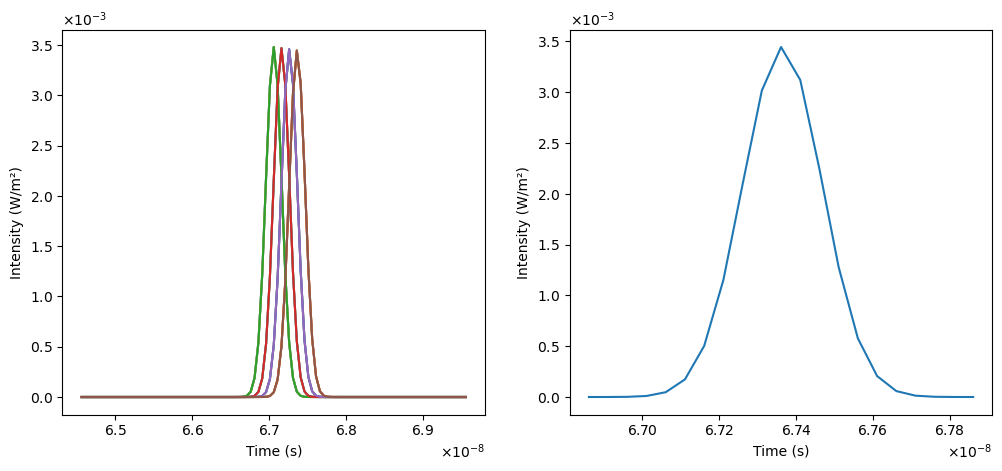

In [16]:
# Visualise the data

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i in range(len(sources)):
    ts = source_data[i]['ts']
    intensities = source_data[i]['intensity']
    axes[0].plot(ts, intensities)
    
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Intensity (W/m²)')
axes[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

index = np.argmax(intensities)
indices = range(index-10, index+11)
axes[1].plot(ts[indices], intensities[indices])

axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Intensity (W/m²)')
axes[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.show()

In [19]:
# Store data

if False:
    with open('ray_tracing_data', 'wb') as file:
        pickle.dump(source_data, file)